# Note

for vocab Size
https://arxiv.org/abs/1902.10339#:~:text=Under%20deep%20neural%20networks%2C%20a,selection%20baselines%20on%20these%20metrics.

# Import Library

In [ ]:
# ========== Data Preparation ==========
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import joblib

# ========== Model Building ==========
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras import backend as K

# ========== Word Embedding ==========
from gensim.models import FastText

# ========== Model Tuning ==========
from keras_tuner.tuners import BayesianOptimization

# ========== Evaluation ==========
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score

# ========== Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick



# Load File & Label Encoder

In [2]:
file_path =  r".\Pre_Dataset\Final.csv"
data = pd.read_csv(file_path)
data.info()

X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158167 entries, 0 to 158166
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    158167 non-null  object
 1   label   158167 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


# Data Info

In [ ]:
import pandas as pd

file_path = r".\Pre_Dataset\Final.csv"
data = pd.read_csv(file_path)

text_column = 'text'

data['text_length'] = data[text_column].astype(str).apply(lambda x: len(x.split()))

text_length_stats = data['text_length'].describe(percentiles=[0.95])  
print(text_length_stats)

count    158176.000000
mean         35.208894
std          53.909820
min           1.000000
50%          19.000000
95%         118.000000
max        1250.000000
Name: text_length, dtype: float64


# Data Preparation

In [3]:
file_path =  r".\Pre_Dataset\Final.csv"
data = pd.read_csv(file_path)

X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

max_words = 20000  # vocab size
max_len = 200  # the max length of the each sentences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padding = pad_sequences(X_seq, maxlen=max_len)

# Train-Valid-Test Split
# First split into train 70%, valid 20% + test 10%
X_train, X_valid_test, Y_train, Y_valid_test = train_test_split(X_padding, Y,  test_size=0.3, stratify=Y, random_state=42)
# get 10% of valid data as test
X_valid, X_test, Y_valid, Y_test = train_test_split( X_valid_test, Y_valid_test, test_size=0.1, stratify=Y_valid_test, random_state=42)

# Undersampling
print("\nClass distribution before resampling (total dataset):", Counter(Y))
undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, Y_train)

print("\nX_train shape", x_train_resampled.shape)
print("Y_train shape", y_train_resampled.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)

print("\nClass distribution after resampling (80% Train Set):", Counter(y_train_resampled))
print("Class distribution (10% Validation Set):", Counter(Y_valid))
print("Class distribution (10% Test Set):", Counter(Y_test))

print(f"\nTotal number of training samples after resampling: {x_train_resampled.shape[0]}")


Class distribution before resampling (total dataset): Counter({0: 143076, 1: 15091})

X_train shape (21128, 200)
Y_train shape (21128,)
X_valid shape (42705, 200)
Y_valid shape (42705,)
X_test shape (4746, 200)
Y_test shape (4746,)

Class distribution after resampling (80% Train Set): Counter({0: 10564, 1: 10564})
Class distribution (10% Validation Set): Counter({0: 38631, 1: 4074})
Class distribution (10% Test Set): Counter({0: 4293, 1: 453})

Total number of training samples after resampling: 21128


# Bi-LSTM Base Model


In [ ]:
MAX_SEQUENCE_LENGTH = 200  
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 20000

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM 
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(32, return_sequences=True)), 
    Bidirectional(LSTM(64, return_sequences=False)),  # by default: activation='tanh', recurrent_activation='sigmoid',return_sequences=False)
    Dense(128, activation='tanh') , 
    Dense(1, activation='sigmoid')  
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(), # Default LR: 0.001
    metrics=["accuracy"]
)

history = model.fit(
    x_train_resampled,
    y_train_resampled,
    epochs=10,  
    batch_size=32,
    validation_data=(X_valid, Y_valid),
    verbose=1
)
model.summary()


# Save model -------------------------------------------------------------------------------------------------
model.save("Bi_LSTM_Default2_Model.h5")
joblib.dump(history.history, "Bi_LSTM_Default2_History.pkl")
print("Model saved successfully!")

Epoch 1/10


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


661/661 ━━━━━━━━━━━━━━━━━━━━ 159s 233ms/step - accuracy: 0.8154 - loss: 0.3894 - val_accuracy: 0.9125 - val_loss: 0.2327
Epoch 2/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 149s 226ms/step - accuracy: 0.9424 - loss: 0.1534 - val_accuracy: 0.9148 - val_loss: 0.2377
Epoch 3/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 141s 213ms/step - accuracy: 0.9675 - loss: 0.0945 - val_accuracy: 0.9084 - val_loss: 0.2507
Epoch 4/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 133s 202ms/step - accuracy: 0.9808 - loss: 0.0548 - val_accuracy: 0.8961 - val_loss: 0.3038
Epoch 5/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 139s 210ms/step - accuracy: 0.9875 - loss: 0.0356 - val_accuracy: 0.8833 - val_loss: 0.4510
Epoch 6/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 147s 222ms/step - accuracy: 0.9905 - loss: 0.0264 - val_accuracy: 0.8786 - val_loss: 0.4914
Epoch 7/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 151s 229ms/step - accuracy: 0.9908 - loss: 0.0244 - val_accuracy: 0.8820 - val_loss: 0.4985
Epoch 8/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 147s 222ms/step - accuracy: 0.9950 - loss: 0.01

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 64)        │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,503,813 (70.59 MB)

 Trainable params: 6,167,937 (23.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,335,876 (47.06 MB)

Model saved successfully!


## Evaluation

In [5]:
# Evaluete Model -------------------------------------------------------------------------------------------------
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_valid, Y_valid, verbose=1)

y_pred_prob = model.predict(X_valid)

661/661 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.9983 - loss: 0.0050
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.8902 - loss: 0.5940
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step


In [ ]:
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Validation Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_valid, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_valid, y_pred, average='macro') 
recall = recall_score(Y_valid, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_valid, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_valid, y_pred))


📌 Train Accuracy: 0.9973
📌 Validation Accuracy: 0.8919

📌 Weighted F1 Score: 0.9060
📌 Precision: 0.7257
📌 Recall: 0.8882

📌 ROC AUC: 0.9477

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     38631
           1       0.46      0.88      0.61      4074

    accuracy                           0.89     42705
   macro avg       0.73      0.89      0.77     42705
weighted avg       0.94      0.89      0.91     42705


📌 Confusion Matrix:
[[34487  4144]
 [  474  3600]]


## confusion_matrix

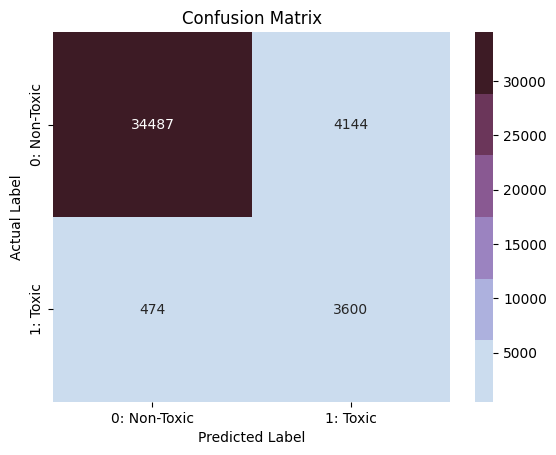

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_valid, y_pred)

sns.heatmap(cm, annot=True, fmt="d",cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['0: Non-Toxic', '1: Toxic'], 
            yticklabels=['0: Non-Toxic', '1: Toxic'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()

## Learning Curve

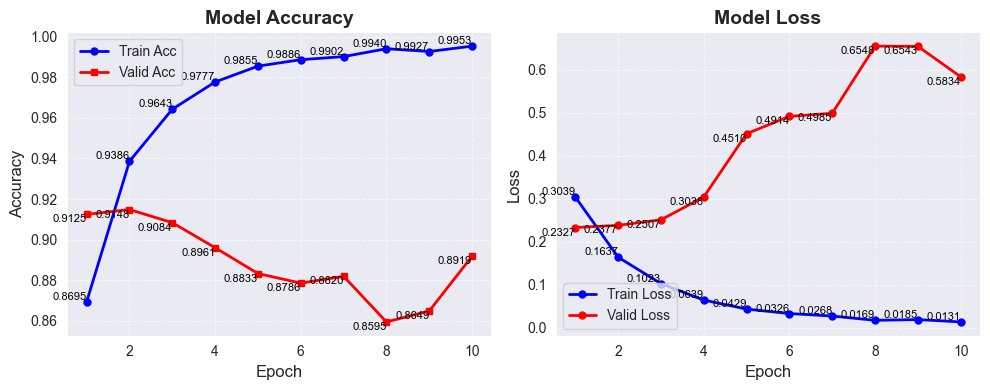

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )
sns.set_style("darkgrid") 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()


## ROC-AUC


📌 ROC AUC: 0.9477


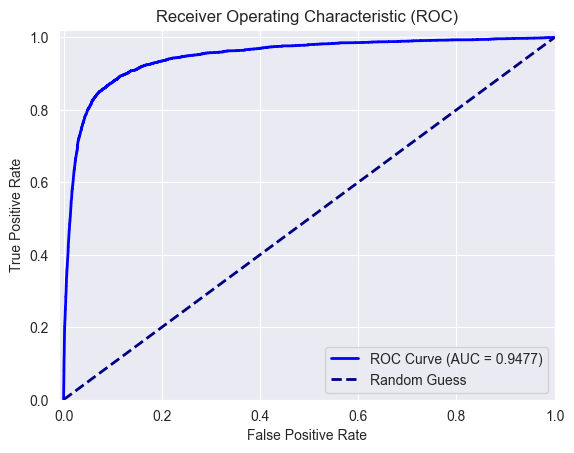

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## PR Curve


📌 Precision-Recall AUC: 0.7384


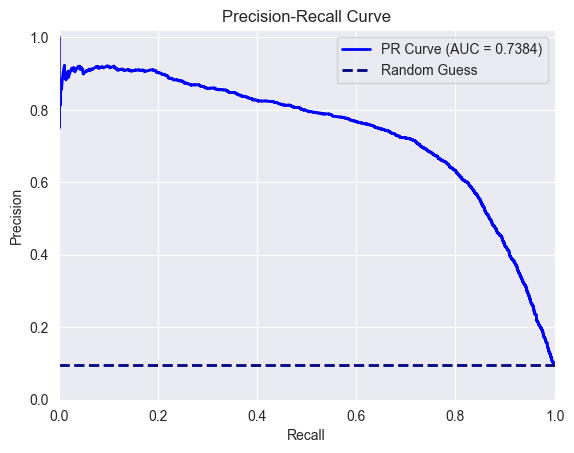

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_valid) / len(Y_valid)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

## Threshold

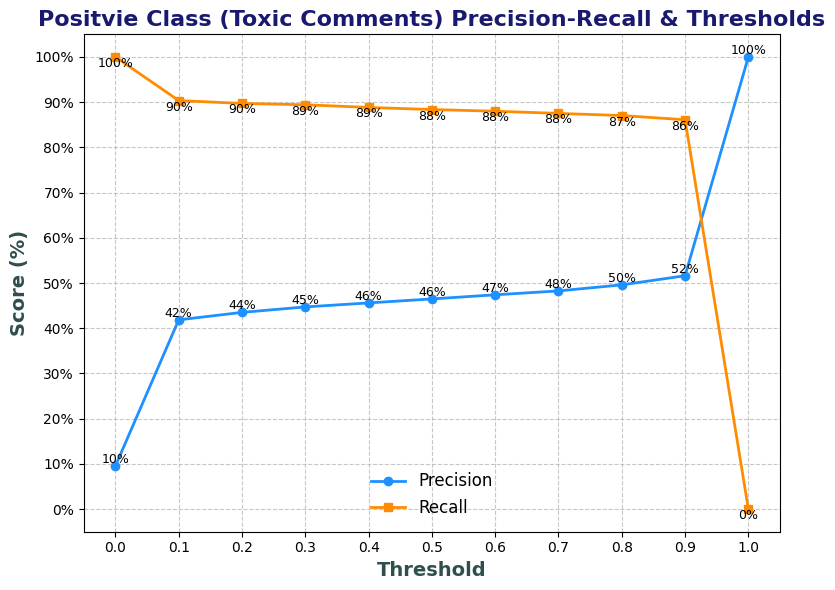

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

precision, recall, thresholds = precision_recall_curve(Y_valid, y_pred_prob)

thresholds_full = np.append(thresholds, 1.0)

interp_thresholds = np.arange(0.0, 1.01, 0.1)  
precision_interp = np.interp(interp_thresholds, thresholds_full, precision)
recall_interp = np.interp(interp_thresholds, thresholds_full, recall)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(interp_thresholds, precision_interp, label="Precision", color='dodgerblue', linewidth=2, marker='o')
plt.plot(interp_thresholds, recall_interp, label="Recall", color='darkorange', linewidth=2, marker='s')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
plt.xticks(interp_thresholds)  

for t, p, r in zip(interp_thresholds, precision_interp, recall_interp):
    plt.text(t, p, f'{p*100:.0f}%', fontsize=9, color='black', ha='center', va='bottom')
    plt.text(t, r, f'{r*100:.0f}%', fontsize=9, color='black', ha='center', va='top')

plt.xlabel("Threshold", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold', color='darkslategray')
plt.title("Positvie Class (Toxic Comments) Precision-Recall & Thresholds", fontsize=16, fontweight='bold', color='midnightblue')
plt.legend(loc='best', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Hyperparameter Tuning 

In [ ]:
MAX_SEQUENCE_LENGTH = 200  
EMBEDDING_DIM = 100
MAX_VOCAB_SIZE = 20000

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_1", min_value=64, max_value=256, step=64),return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.4, step=0.1)))

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_2", min_value=32, max_value=128, step=32), return_sequences=True )))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.2, max_value=0.4, step=0.1)))

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_3", min_value=16, max_value=64, step=16), return_sequences=False )))
    model.add(Dropout(hp.Float("dropout_3", min_value=0.2, max_value=0.4, step=0.1)))
    
    model.add(Dense(units=hp.Int("dense_units", min_value=16, max_value=64, step=16), 
                    activation=hp.Choice("activation", ["relu"]),  
                    kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_reg", min_value=0.001, max_value=0.1, step=0.01))))
    model.add(Dense(1, activation="sigmoid"))

    optimizer_choice = hp.Choice('optimizer', ['adam'])
    learning_rate = hp.Choice("learning_rate", [0.0001, 0.003, 0.01, 0.3])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer = optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir_Bi_LSTM',
    project_name='2_HP_ReleAdam_NoFastText'
)

tuner.search(x_train_resampled,y_train_resampled,
             epochs=5,
             batch_size=32,
             validation_data=(X_valid,Y_valid))


Trial 5 Complete [01h 14m 52s]
val_accuracy: 0.9046013355255127

Best val_accuracy So Far: 0.9372204542160034
Total elapsed time: 05h 55m 32s


## Best HP

In [14]:
best_model = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""Best Hyperparameter:
        Bi-LSTM  Layer 1: {best_model.get('LSTM_layer_1')}
        Bi-LSTM  Layer 2: {best_model.get('LSTM_layer_2')}
        Bi-LSTM  Layer 3: {best_model.get('LSTM_layer_3')}
        Dropout 1: {best_model.get('dropout_1')}
        Dropout 2: {best_model.get('dropout_2')}
        Dropout 3: {best_model.get('dropout_3')}
        Dense : {best_model.get('dense_units')}
        L2 Regularizers: {best_model.get('l2_reg')}
        Activitation : {best_model.get('activation')}
        Learning Rate : {best_model.get('learning_rate')}
        Optimizer Choice: {best_model.get('optimizer')}
        """)

Best Hyperparameter:
        Bi-LSTM  Layer 1: 256
        Bi-LSTM  Layer 2: 64
        Bi-LSTM  Layer 3: 16
        Dropout 1: 0.2
        Dropout 2: 0.30000000000000004
        Dropout 3: 0.30000000000000004
        Dense : 32
        L2 Regularizers: 0.031
        Activitation : relu
        Learning Rate : 0.0001
        Optimizer Choice: adam
        


## Model

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

model = build_model(best_model)
history = model.fit(x_train_resampled, y_train_resampled, 
                    epochs=15, batch_size=32, 
                    validation_data=(X_valid, Y_valid),
                    callbacks=[early_stopping]
                )
model.summary()

# Save Model ---------------------------------------------------------------------------------------------------------------------\\\

joblib.dump(tuner, "2_HP_ReluAdam_Tuner.pkl")
model.save("2_HP_ReluAdam_Model.h5") 
joblib.dump(history.history, "2_HP_ReluAdam_History.pkl")

print("Saved successfully!")

Epoch 1/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 1203s 2s/step - accuracy: 0.6529 - loss: 1.4541 - val_accuracy: 0.9000 - val_loss: 0.8451
Epoch 2/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 1191s 2s/step - accuracy: 0.8423 - loss: 0.8587 - val_accuracy: 0.8635 - val_loss: 0.6770
Epoch 3/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 1245s 2s/step - accuracy: 0.9282 - loss: 0.4869 - val_accuracy: 0.8677 - val_loss: 0.5131
Epoch 4/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 1244s 2s/step - accuracy: 0.9475 - loss: 0.3135 - val_accuracy: 0.8835 - val_loss: 0.3967
Epoch 5/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 1226s 2s/step - accuracy: 0.9647 - loss: 0.2055 - val_accuracy: 0.8932 - val_loss: 0.3582
Epoch 6/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 1132s 2s/step - accuracy: 0.9732 - loss: 0.1487 - val_accuracy: 0.8663 - val_loss: 0.4014
Epoch 7/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 1221s 2s/step - accuracy: 0.9758 - loss: 0.1267 - val_accuracy: 0.8827 - val_loss: 0.3777
Epoch 8/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 1674s 3s/step - accuracy: 0.9793 - loss: 0.1045 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200, 512)       │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 200, 128)       │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32)             │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,138,629 (34.86 MB)

 Trainable params: 3,046,209 (11.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,092,420 (23.24 MB)

Saved successfully!


## Evaluation

In [7]:
# Evaluete Model -------------------------------------------------------------------------------------------------
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_valid, Y_valid, verbose=1)

y_pred_prob = model.predict(X_valid)

661/661 ━━━━━━━━━━━━━━━━━━━━ 223s 337ms/step - accuracy: 0.9750 - loss: 0.1523
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 437s 327ms/step - accuracy: 0.8908 - loss: 0.3656
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 702s 526ms/step


### Threshold 0.5

In [ ]:
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Validation Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_valid, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_valid, y_pred, average='macro') 
recall = recall_score(Y_valid, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)
print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_valid, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_valid, y_pred))


📌 Train Accuracy: 0.9764
📌 Validation Accuracy: 0.8932

📌 Weighted F1 Score: 0.9072
📌 Precision: 0.7281
📌 Recall: 0.8937

📌 ROC AUC: 0.9554

📌 Precision-Recall AUC: 0.8196

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     38631
           1       0.47      0.89      0.61      4074

    accuracy                           0.89     42705
   macro avg       0.73      0.89      0.78     42705
weighted avg       0.94      0.89      0.91     42705


📌 Confusion Matrix:
[[34498  4133]
 [  430  3644]]


### Threshold 0.9

In [ ]:
train_y_pred_prob = model.predict(x_train_resampled)
y_pred_prob = model.predict(X_valid)

train_y_pred = (train_y_pred_prob > 0.9).astype(int)
valid_accuracy = accuracy_score(y_train_resampled, train_y_pred) 
print(f"📌 Train Accuracy: {valid_accuracy:.4f}")

y_pred = (y_pred_prob > 0.9).astype(int)
valid_accuracy = accuracy_score(Y_valid, y_pred)
print(f"📌 Validation Accuracy: {valid_accuracy:.4f}")

f1_weighted = f1_score(Y_valid, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_valid, y_pred, average='macro') 
recall = recall_score(Y_valid, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)
print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_valid, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_valid, y_pred))

📌 Train Accuracy: 0.9580
📌 Validation Accuracy: 0.9365

📌 Weighted F1 Score: 0.9405
📌 Precision: 0.8037
📌 Recall: 0.8906

📌 ROC AUC: 0.9554

📌 Precision-Recall AUC: 0.8196

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     38631
           1       0.63      0.83      0.71      4074

    accuracy                           0.94     42705
   macro avg       0.80      0.89      0.84     42705
weighted avg       0.95      0.94      0.94     42705


📌 Confusion Matrix:
[[36598  2033]
 [  677  3397]]


## Confusion Matrix (ThresHold 0.5)

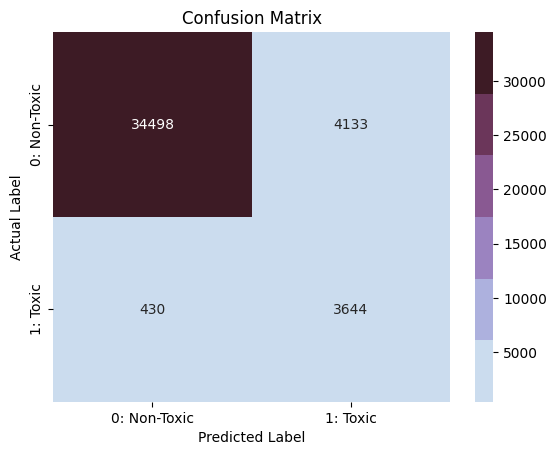

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_valid, y_pred)

sns.heatmap(cm, annot=True, fmt="d",cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['0: Non-Toxic', '1: Toxic'], 
            yticklabels=['0: Non-Toxic', '1: Toxic'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()

## Learning Curve

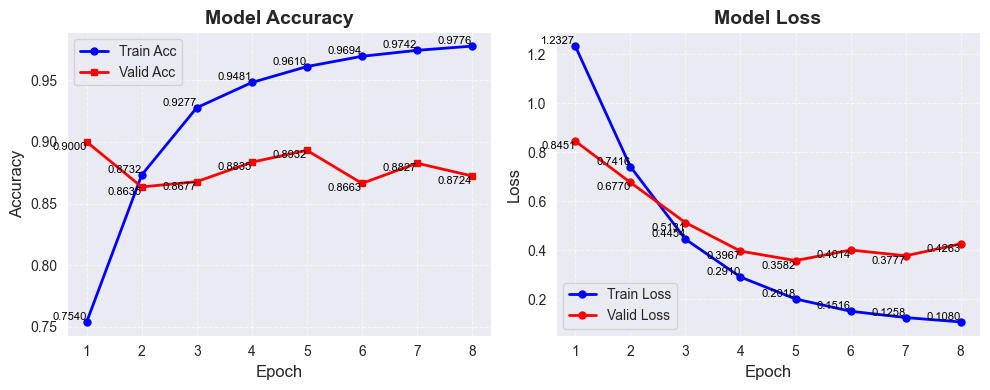

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )


sns.set_style("darkgrid") 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()

## ROC-AUC


📌 ROC AUC: 0.9554


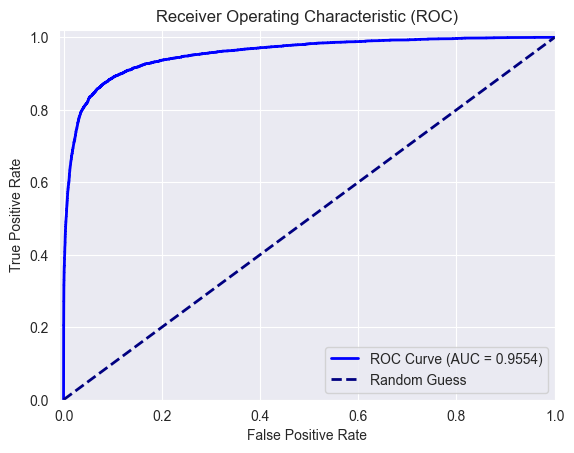

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## PR Curve


📌 Precision-Recall AUC: 0.8196


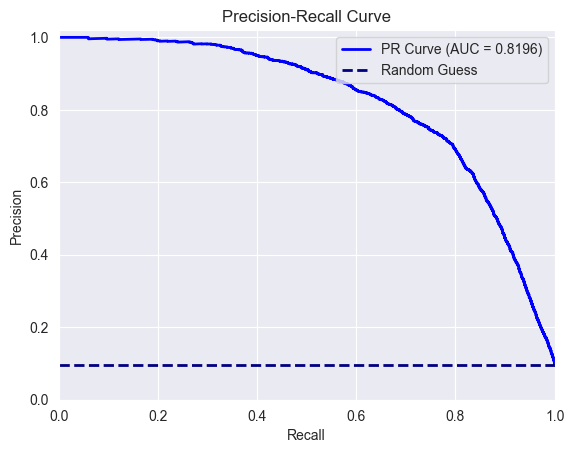

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_valid) / len(Y_valid)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

## Precision-Recall & Thresholds

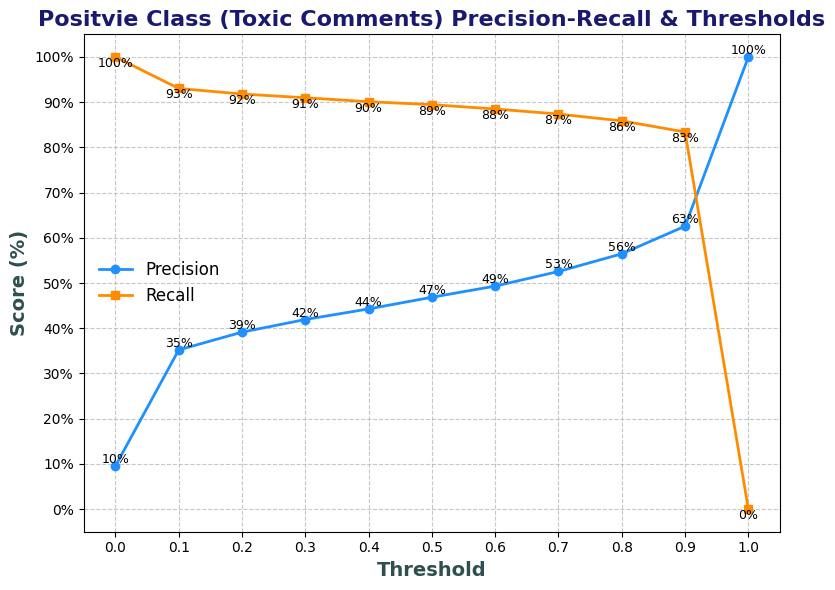

In [ ]:
precision, recall, thresholds = precision_recall_curve(Y_valid, y_pred_prob)

thresholds_full = np.append(thresholds, 1.0)

# Create interpolation points for thresholds from 0 to 1 with a step of 0.1
interp_thresholds = np.arange(0.0, 1.01, 0.1)  
# Interpolate the precision and recall based on the new thresholds
precision_interp = np.interp(interp_thresholds, thresholds_full, precision)
recall_interp = np.interp(interp_thresholds, thresholds_full, recall)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(interp_thresholds, precision_interp, label="Precision", color='dodgerblue', linewidth=2, marker='o')
plt.plot(interp_thresholds, recall_interp, label="Recall", color='darkorange', linewidth=2, marker='s')

# Set the y-axis to percentage format
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
# Set the x-axis scale value to the threshold
plt.xticks(interp_thresholds)  

# Add the percentage text of precision and recall at each threshold position
for t, p, r in zip(interp_thresholds, precision_interp, recall_interp):
    plt.text(t, p, f'{p*100:.0f}%', fontsize=9, color='black', ha='center', va='bottom')
    plt.text(t, r, f'{r*100:.0f}%', fontsize=9, color='black', ha='center', va='top')

plt.xlabel("Threshold", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold', color='darkslategray')
plt.title("Positvie Class (Toxic Comments) Precision-Recall & Thresholds", fontsize=16, fontweight='bold', color='midnightblue')
plt.legend(loc='best', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Fine Tuning

In [ ]:
MAX_SEQUENCE_LENGTH = 200  
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 20000

# https://fasttext.cc/docs/en/english-vectors.html 
fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)

# declare matrix
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        if word in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))   

# embedding_matrix = np.load("embedding_matrix_20k_200.npy")

embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False  
)
# np.save("embedding_matrix_20k.npy", embedding_matrix)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K


# -------------------------------------------------------------------------------------------------------------------
# When saving the model, Keras will automatically recognize my_custom_loss and load it correctly
@register_keras_serializable(package="CustomLoss")
# Function focal_loss code et from GitHub (aldi-dimara, 2018)
# Gamma, Alpha default values ​​recommended by the paper (Lin et al., 2018) # https://arxiv.org/pdf/1708.02002v2 
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.45):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    # Predicted probability of the correct class
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    # Alpha factor for balancing class imbalance. 
    alpha_factor = K.ones_like(y_true)*alpha
    # Dynamically assigns different alpha values to different classes
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    # Cross-entropy loss
    cross_entropy = -K.log(pt)
    # Alpha > 0.5, then class 1 weigth > class 0 weigth. Alpha < 0.5, then class 0 weigth > class 1 weigth
    weight = alpha_t * K.pow((1-pt), gamma) #alpha_t*(1 - pt) ^ gamma
    loss = weight * cross_entropy
    # loss = K.sum(loss, axis=1)
    loss = K.mean(loss, axis=1)
    return loss

model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True)),  
    Dropout(0.2),  
    Bidirectional(LSTM(64, return_sequences=True)), 
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.4),
    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1, activation='sigmoid') 
])
optimizer = Adam(learning_rate=0.003)

model.compile(
    loss=focal_loss,
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Reduce learning rate when loss has stopped reducing
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,        # Decrease LR (current LR * 0.5)
    patience=1,           # If val_loss does not improve for 1 epoch, reduce LR
    min_lr=0.0001,        # Setting minimum learning rate to prevent it from being too low
    verbose=1             
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train_resampled,
    y_train_resampled,
    epochs=15, 
    batch_size=32,
    validation_data=(X_valid, Y_valid),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
model.summary()

Epoch 1/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 182s 265ms/step - accuracy: 0.6699 - loss: 0.0860 - val_accuracy: 0.8304 - val_loss: 0.0653 - learning_rate: 0.0030
Epoch 2/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 180s 273ms/step - accuracy: 0.7475 - loss: 0.0628 - val_accuracy: 0.8810 - val_loss: 0.0519 - learning_rate: 0.0030
Epoch 3/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 180s 273ms/step - accuracy: 0.7845 - loss: 0.0562 - val_accuracy: 0.9158 - val_loss: 0.0411 - learning_rate: 0.0030
Epoch 4/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8108 - loss: 0.0507
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
661/661 ━━━━━━━━━━━━━━━━━━━━ 181s 274ms/step - accuracy: 0.8108 - loss: 0.0507 - val_accuracy: 0.8373 - val_loss: 0.0523 - learning_rate: 0.0030
Epoch 5/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8312 - loss: 0.0458
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.
661/661 ━━━━━━━━━━━━━━━━━━━━ 183s 277ms/step - accuracy: 0.83

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,990,245 (26.67 MB)

 Trainable params: 330,081 (1.26 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

 Optimizer params: 660,164 (2.52 MB)

In [ ]:
model.save("Fine_Model.keras") 
joblib.dump(history.history, "Fine_History.pkl")

['Fine_History.pkl']

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score

train_y_pred_prob = model.predict(x_train_resampled)
y_pred_prob = model.predict(X_valid)

661/661 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step


In [ ]:
train_y_pred = (train_y_pred_prob > 0.53).astype(int)
valid_accuracy = accuracy_score(y_train_resampled, train_y_pred) 
print(f"📌 Train Accuracy: {valid_accuracy:.4f}")

y_pred = (y_pred_prob > 0.53).astype(int)
valid_accuracy = accuracy_score(Y_valid, y_pred)
print(f"📌 Validation Accuracy: {valid_accuracy:.4f}")

f1_weighted = f1_score(Y_valid, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_valid, y_pred, average='macro') 
recall = recall_score(Y_valid, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_valid, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_valid, y_pred))


📌 Train Accuracy: 0.8535
📌 Validation Accuracy: 0.9286

📌 Weighted F1 Score: 0.9316
📌 Precision: 0.7874
📌 Recall: 0.8405

📌 ROC AUC: 0.9294

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     38631
           1       0.60      0.73      0.66      4074

    accuracy                           0.93     42705
   macro avg       0.79      0.84      0.81     42705
weighted avg       0.94      0.93      0.93     42705


📌 Confusion Matrix:
[[36675  1956]
 [ 1093  2981]]


## confusion_matrix

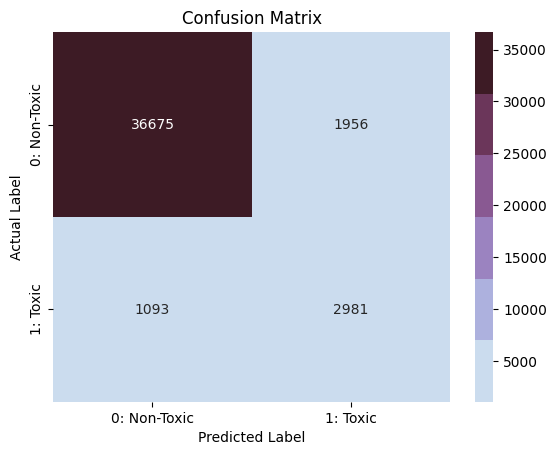

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_valid, y_pred)

sns.heatmap(cm, annot=True, fmt="d",cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['0: Non-Toxic', '1: Toxic'], 
            yticklabels=['0: Non-Toxic', '1: Toxic'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## ROC-AUC


📌 ROC AUC: 0.9294


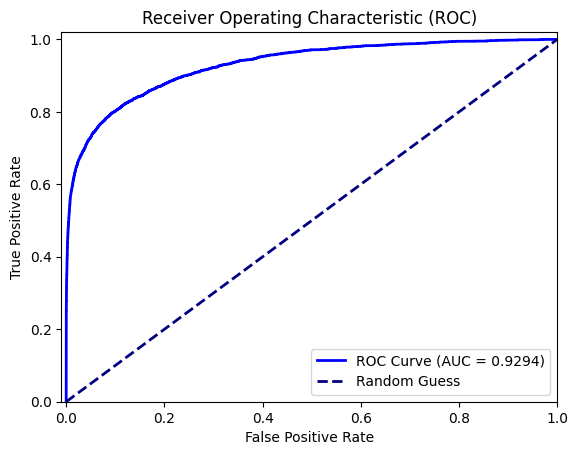

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## PR Curve


📌 Precision-Recall AUC: 0.7666


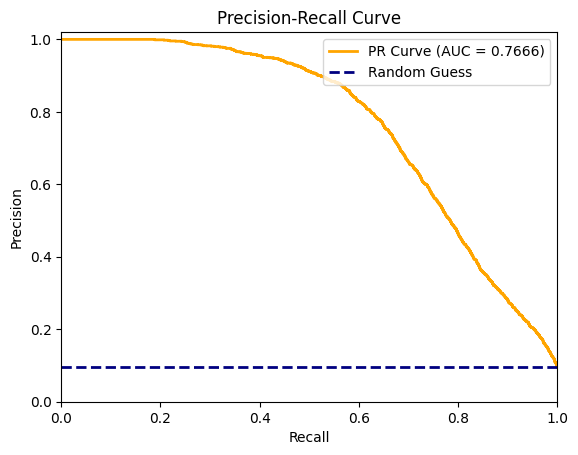

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_valid) / len(Y_valid)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## Threshold

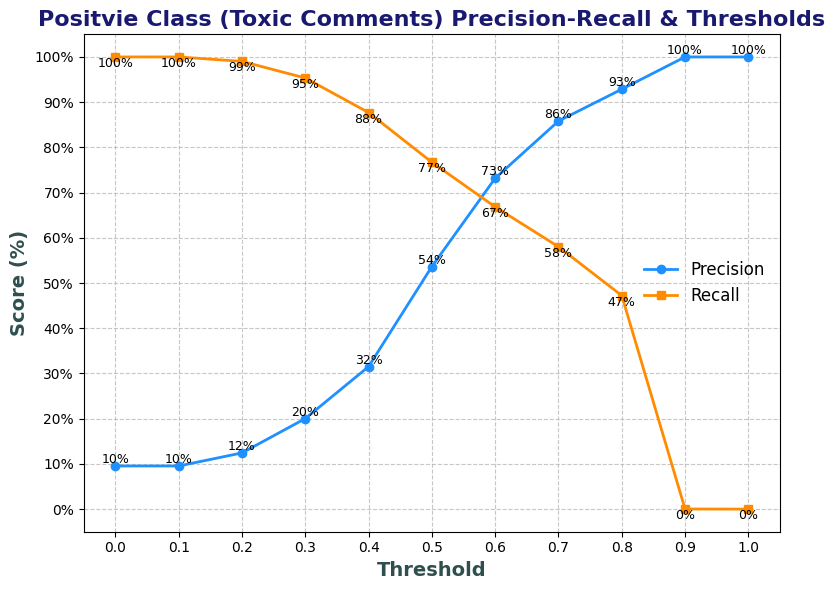

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

precision, recall, thresholds = precision_recall_curve(Y_valid, y_pred_prob)

thresholds_full = np.append(thresholds, 1.0)

interp_thresholds = np.arange(0.0, 1.01, 0.1)  
precision_interp = np.interp(interp_thresholds, thresholds_full, precision)
recall_interp = np.interp(interp_thresholds, thresholds_full, recall)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(interp_thresholds, precision_interp, label="Precision", color='dodgerblue', linewidth=2, marker='o')
plt.plot(interp_thresholds, recall_interp, label="Recall", color='darkorange', linewidth=2, marker='s')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
plt.xticks(interp_thresholds)  

for t, p, r in zip(interp_thresholds, precision_interp, recall_interp):
    plt.text(t, p, f'{p*100:.0f}%', fontsize=9, color='black', ha='center', va='bottom')
    plt.text(t, r, f'{r*100:.0f}%', fontsize=9, color='black', ha='center', va='top')

plt.xlabel("Threshold", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold', color='darkslategray')
plt.title("Positvie Class (Toxic Comments) Precision-Recall & Thresholds", fontsize=16, fontweight='bold', color='midnightblue')
plt.legend(loc='best', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Learning Curve

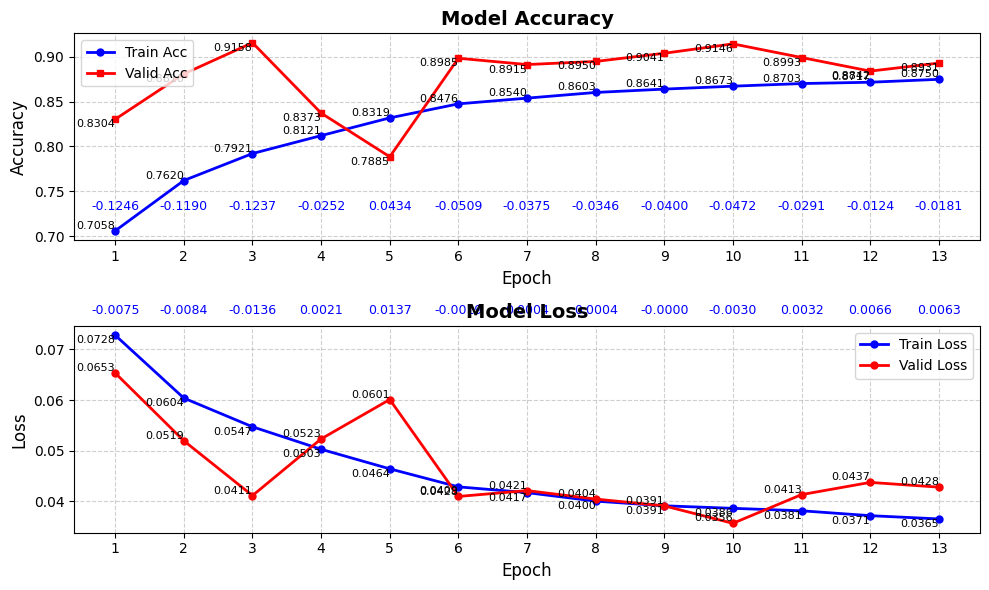

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) +0.02, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) +0.04, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')

plt.tight_layout()
plt.show()


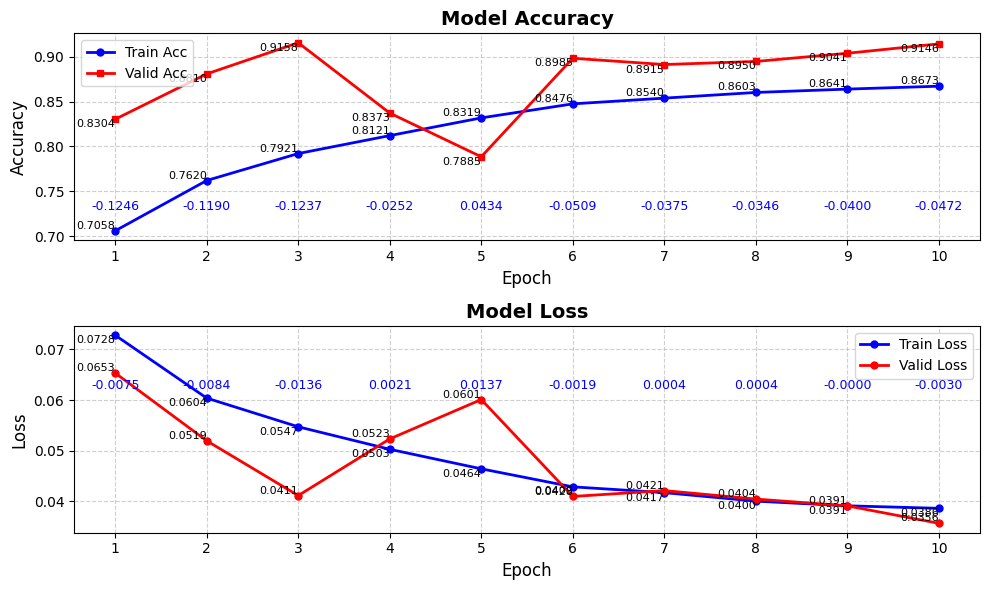

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy'][:10]
val_acc = history.history['val_accuracy'][:10]
loss = history.history['loss'][:10]
val_loss = history.history['val_loss'][:10]
epochs = range(1, len(accuracy) + 1 )


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) +0.02, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) +0.023, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')


plt.tight_layout()
plt.show()


# Test on test set

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="CustomLoss")
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.53):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1-pt), gamma)
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = load_model(
    r"Model Saved/Bi-LSTM/Fine_Model.keras",
    custom_objects={'focal_loss': focal_loss}
)
y_pred_prob = model.predict(X_test)


In [ ]:
y_pred = (y_pred_prob > 0.5).astype(int)
valid_accuracy = accuracy_score(Y_test, y_pred)
print(f"📌 Test Accuracy: {valid_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_test, y_pred, average='macro') 
recall = recall_score(Y_test, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)
print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


📌 Test Accuracy: 0.9096

📌 Weighted F1 Score: 0.9171
📌 Precision: 0.7459
📌 Recall: 0.8444

📌 ROC AUC: 0.9165

📌 Precision-Recall AUC: 0.7329

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      4293
           1       0.52      0.76      0.62       453

    accuracy                           0.91      4746
   macro avg       0.75      0.84      0.78      4746
weighted avg       0.93      0.91      0.92      4746


📌 Confusion Matrix:
[[3971  322]
 [ 107  346]]


## Confusion Matrix

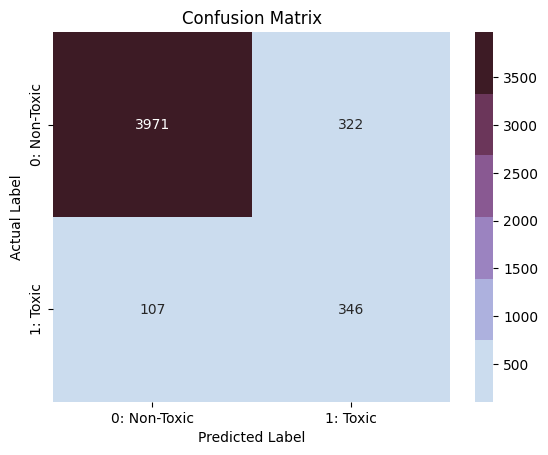

In [ ]:
cm = confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d",cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['0: Non-Toxic', '1: Toxic'], 
            yticklabels=['0: Non-Toxic', '1: Toxic'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## ROC Curve


📌 ROC AUC: 0.9165


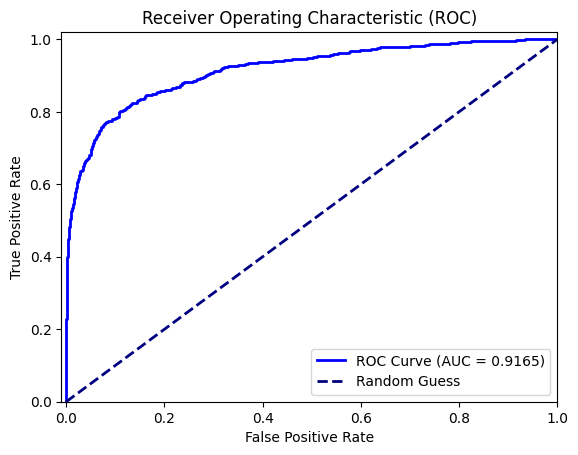

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## PR Curve


📌 Precision-Recall AUC: 0.7329


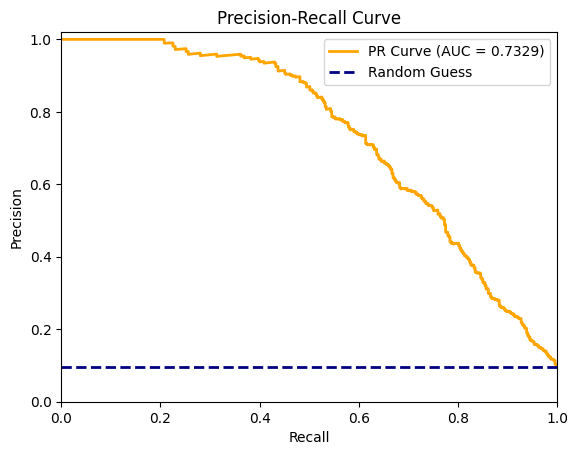

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## Threshold

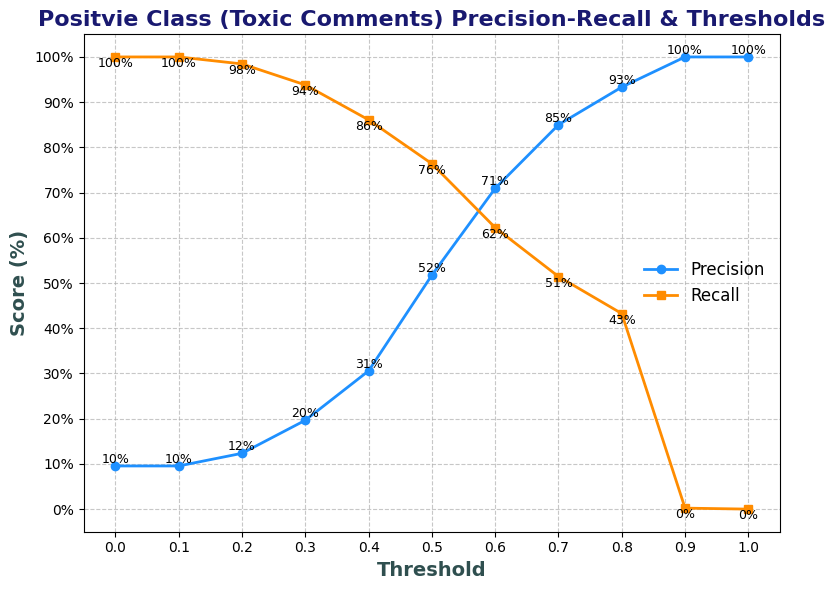

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_prob)

thresholds_full = np.append(thresholds, 1.0)

interp_thresholds = np.arange(0.0, 1.01, 0.1)  
precision_interp = np.interp(interp_thresholds, thresholds_full, precision)
recall_interp = np.interp(interp_thresholds, thresholds_full, recall)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(interp_thresholds, precision_interp, label="Precision", color='dodgerblue', linewidth=2, marker='o')
plt.plot(interp_thresholds, recall_interp, label="Recall", color='darkorange', linewidth=2, marker='s')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
plt.xticks(interp_thresholds)  

for t, p, r in zip(interp_thresholds, precision_interp, recall_interp):
    plt.text(t, p, f'{p*100:.0f}%', fontsize=9, color='black', ha='center', va='bottom')
    plt.text(t, r, f'{r*100:.0f}%', fontsize=9, color='black', ha='center', va='top')

plt.xlabel("Threshold", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold', color='darkslategray')
plt.title("Positvie Class (Toxic Comments) Precision-Recall & Thresholds", fontsize=16, fontweight='bold', color='midnightblue')
plt.legend(loc='best', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
